In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Activation, RepeatVector, TimeDistributed, Conv1D
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import math

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

plt.switch_backend('TkAgg')
%matplotlib inline

# get data
fname = "./datos.csv"
data = pd.read_csv(fname, index_col=0)
data.index = data.index.astype("datetime64[ns]")
data.sort_index(ascending=True, inplace=True)
data_fixed = data.groupby(lambda x: x.weekofyear).transform(lambda x: x.fillna(x.mean()))
all_levels = data_fixed.iloc[:, :6].values.astype("float64")
names = data_fixed.columns[:6]
river_i_list = [0,1,2,3,4,5]
river_i_list = [5]

np.random.seed(7)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Using TensorFlow backend.


In [2]:
# usuful functions


def train_test_split(dataset, train_frac):
    train_size = int(len(dataset)*train_frac)
    return dataset[:train_size, :], dataset[train_size: ,:]


def create_datasets(dataset, look_back=1, look_ahead=1):
    data_x, data_y = [], []
    for i in range(len(dataset)-look_back-look_ahead+1):
        window = dataset[i:(i+look_back), 0]
        data_x.append(window)
        data_y.append(dataset[i + look_back:i + look_back + look_ahead , 0])
    return np.array(data_x), np.array(data_y)


def reverse_scale(data, mean, std):
    return data*std + mean


def calculate_error(train_y, test_y, pred_train, pred_test):
    test_score = math.sqrt(mean_squared_error(test_y, pred_test))
    train_score = math.sqrt(mean_squared_error(train_y, pred_train))
    return train_score, test_score


def mean_absolute_percentage(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100


def root_mse(pred_test, test_y):
    t = []
    for i in range(20):
        score = math.sqrt(mean_squared_error(pred_test[:,i,:], test_y[:,i,:]))
        t.append(score)
        print(i+1, "  ->  ", score)
        
    return score


def plot_errors(pred_test, test_y, errors):
    plt.figure(figsize=(20,10))
    plt.subplot(311)
    plt.plot(test_y[:,23,:], label="Observed")
    plt.plot(pred_test[:,23,:], color="red", label="Predicted, MAPE: "+ str(round(errors[23], 5))+"%")
    plt.title("24 step ahead prediction")
    plt.ylabel("River Level")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    
    plt.subplot(312)
    plt.plot(pred_test[:,47,:], color="red", label="Predicted, MAPE: "+ str(round(errors[47], 5))+"%")
    plt.plot(test_y[:,47,:], label="Observed")
    plt.title("48 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)

    plt.subplot(313)
    plt.plot(pred_test[:,71,:], color="red", label="Predicted, MAPE: "+ str(round(errors[71], 5))+"%")
    plt.plot(test_y[:,71,:], label="Observed")
    plt.title("72 step ahead prediction")
    plt.legend(loc=1, fontsize = 8, framealpha=0.8)
    plt.tight_layout()
    plt.show()
    

def build_seq2seq_model(look_ahead=1):
    m = Sequential()
    
    # encoder
    m.add(GRU(16, input_shape=(None, 1)))
    # m.add(GRU(16, input_dim = 1))
    
    # repeat for the number of steps out
    m.add(RepeatVector(look_ahead))
    
    # decoder
    m.add(GRU(8, return_sequences=True))
    m.add(GRU(8, return_sequences=True))
    
    # split the output into timesteps
    m.add(TimeDistributed(Dense(1)))
    
    m.compile(loss='mse', optimizer='rmsprop')
    
    m.summary()
    return m


cells=1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_36 (GRU)                 (None, 8)                 240       
_________________________________________________________________
repeat_vector_17 (RepeatVect (None, 73, 8)             0         
_________________________________________________________________
gru_37 (GRU)                 (None, 73, 8)             408       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 73, 1)             9         
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Train on 10636 samples, validate on 2660 samples
Epoch 1/10
 - 28s - loss: 0.5526 - val_loss: 0.0618
Epoch 2/10
 - 19s - loss: 0.3107 - val_loss: 0.0535
Epoch 3/10
 - 19s - loss: 0.2647 - val_loss: 0.0446
Epoch 4/10
 - 19s - loss: 0.2485 - val_loss: 0.0405
Epoch 5/10


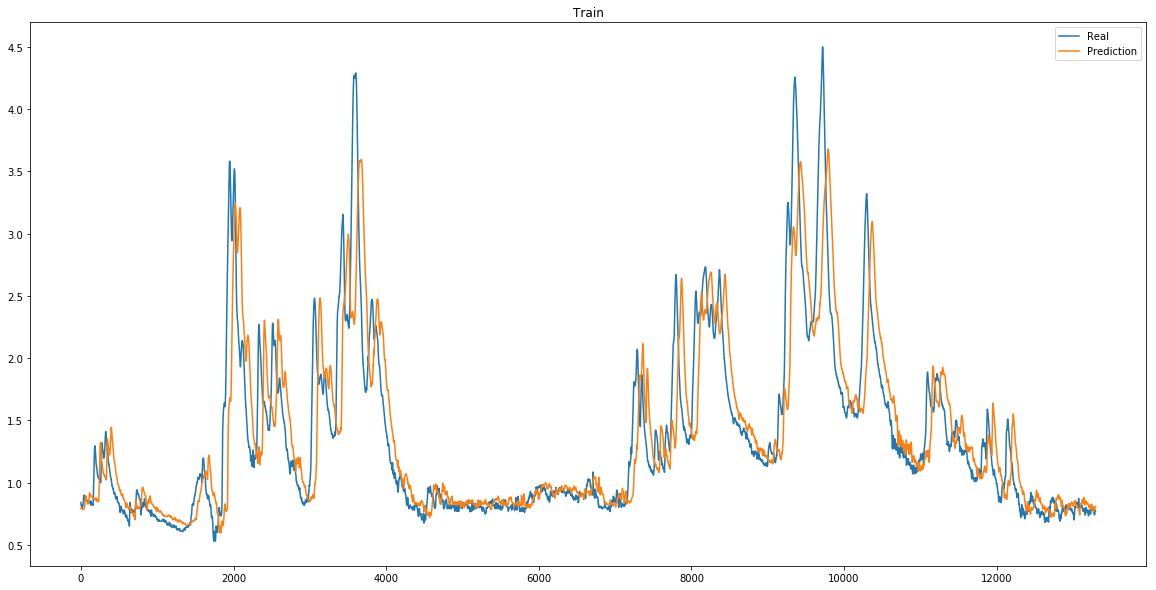

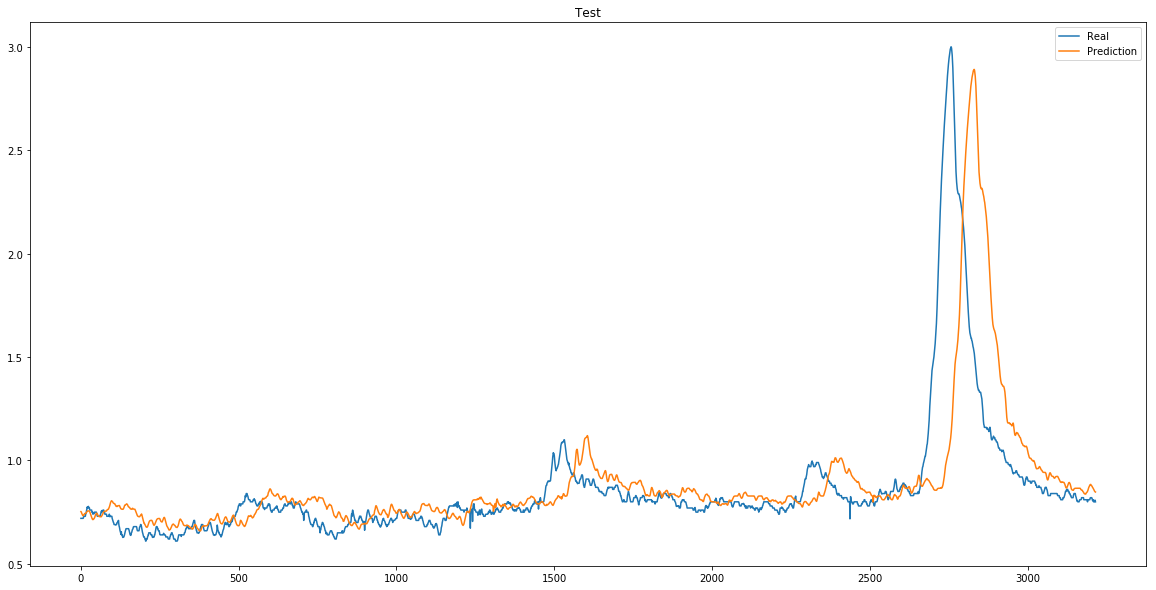

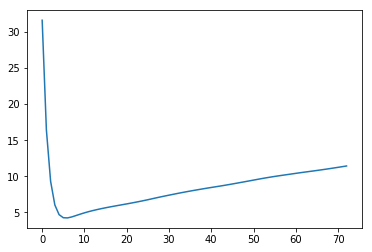

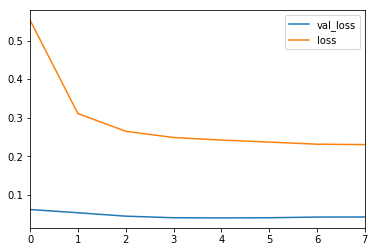

cells=2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_38 (GRU)                 (None, 16)                864       
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 73, 16)            0         
_________________________________________________________________
gru_39 (GRU)                 (None, 73, 8)             600       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 73, 1)             9         
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________
Train on 10636 samples, validate on 2660 samples
Epoch 1/10
 - 32s - loss: 0.4428 - val_loss: 0.0591
Epoch 2/10
 - 21s - loss: 0.2635 - val_loss: 0.0401
Epoch 3/10
 - 21s - loss: 0.2350 - val_loss: 0.0409
Epoch 4/10
 - 21s - loss: 0.2240 - val_loss: 0.0484
Epoch 5

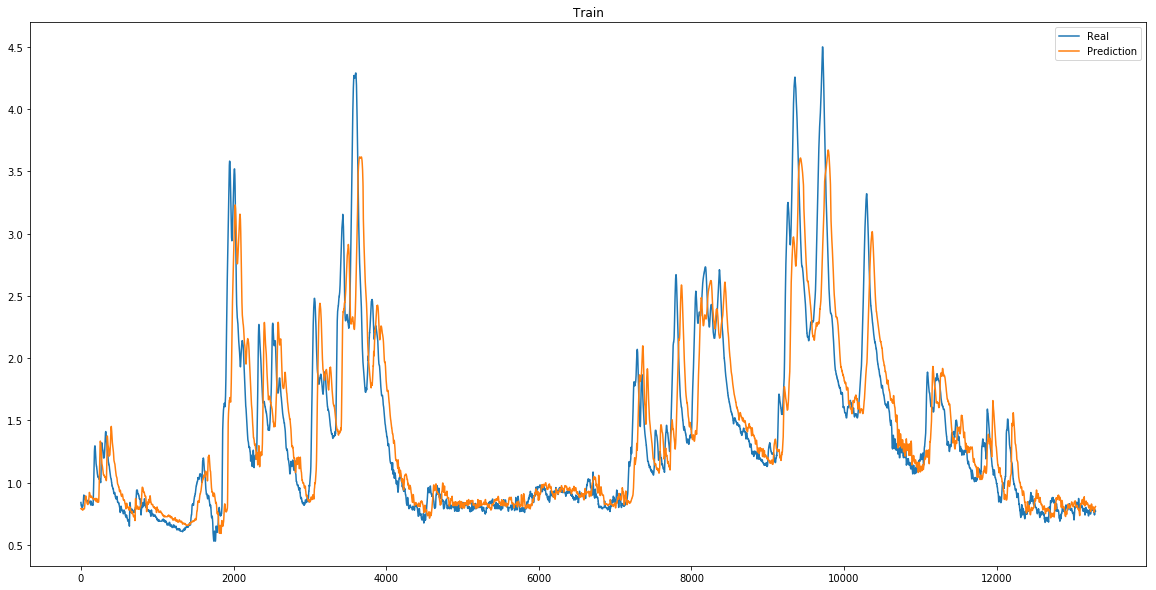

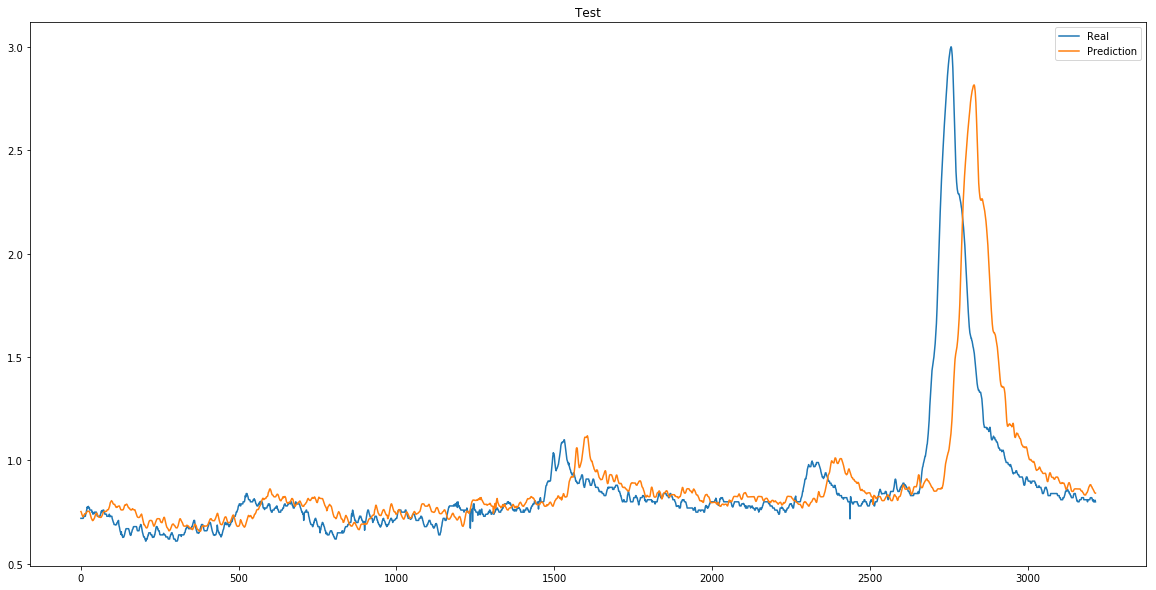

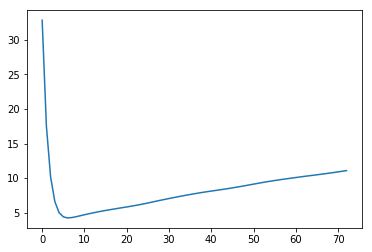

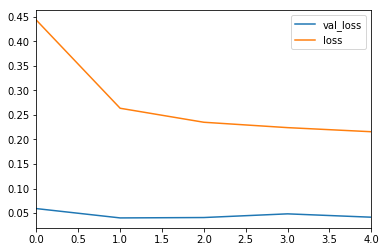

cells=3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_40 (GRU)                 (None, 24)                1872      
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 73, 24)            0         
_________________________________________________________________
gru_41 (GRU)                 (None, 73, 8)             792       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 73, 1)             9         
Total params: 2,673
Trainable params: 2,673
Non-trainable params: 0
_________________________________________________________________
Train on 10636 samples, validate on 2660 samples
Epoch 1/10
 - 33s - loss: 0.7995 - val_loss: 0.0582
Epoch 2/10
 - 22s - loss: 0.2724 - val_loss: 0.0462
Epoch 3/10
 - 25s - loss: 0.2425 - val_loss: 0.0414
Epoch 4/10
 - 23s - loss: 0.2257 - val_loss: 0.0415
Epoch 5

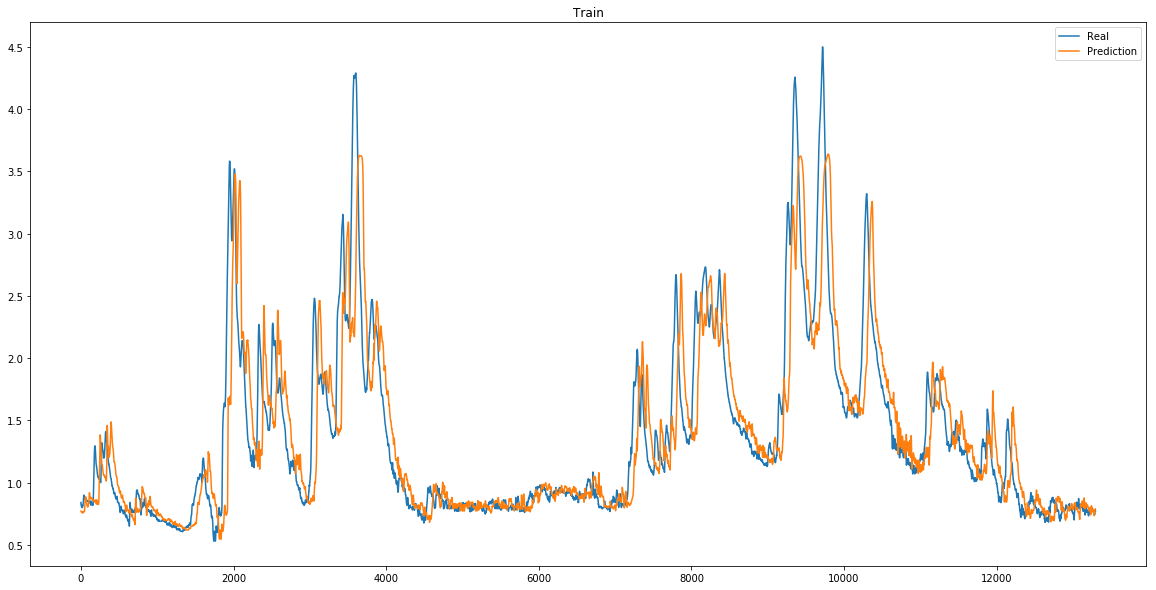

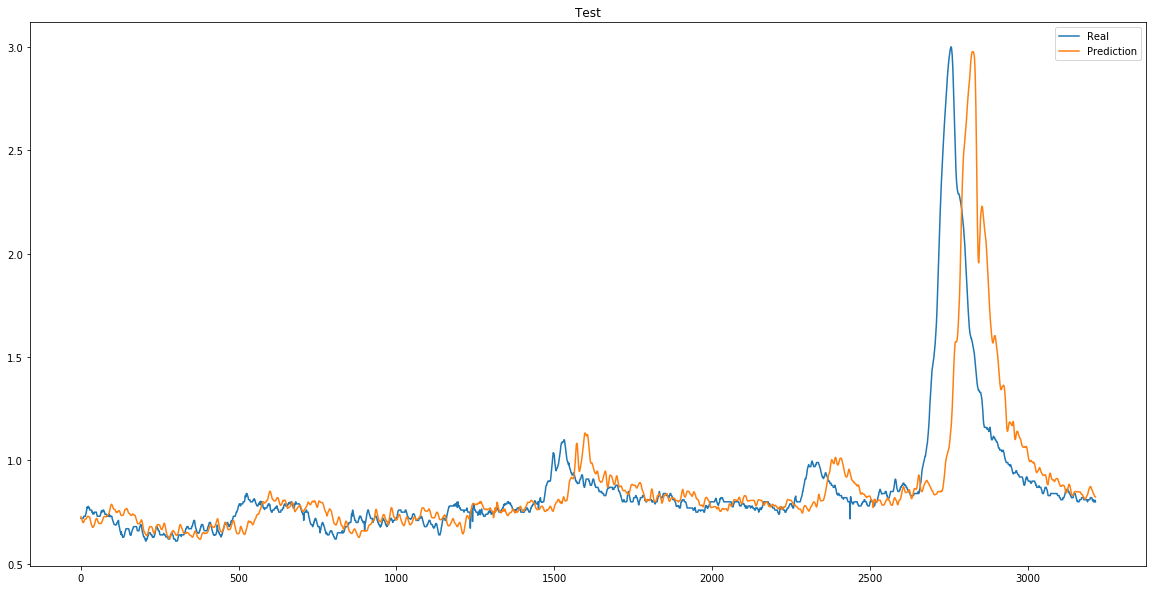

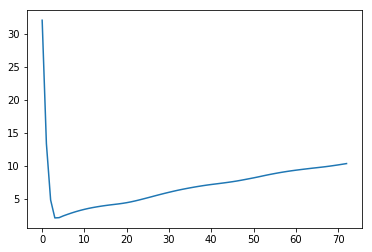

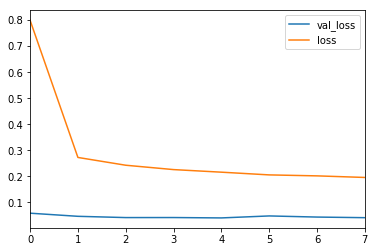

In [7]:
for i in range(1, 4):
    print(f"cells={i}")
    scores = []
    history = []
    model_list = []
    river_i_list = [5]
    look_back = 24*3
    look_ahead = 72+1
    N = 100 * 24 * 7
    split = 0.8
    batch_size=200


    river = all_levels[:N, 5]  # zgz
    # river = np.diff(river, axis=0)

    # normalize
    river_mean, river_std = river.mean(), river.std()
    river = preprocessing.scale(river)[:, None]

    # split data into train and test subsets
    train, test = train_test_split(river, split)
    train_x, train_y = create_datasets(train, look_back, look_ahead)
    test_x, test_y = create_datasets(test, look_back, look_ahead)

    # reshape the data to match Keras LSTM gate input [samples, time steps, features]
    train_x = train_x[:, :, None]
    train_y = train_y[:, :, None]

    test_x = test_x[:, :, None]
    test_y = test_y[:, :, None]

    # MODEL
    m = Sequential()
    m.add(GRU(8*i, input_shape=(None, 1)))
    m.add(RepeatVector(look_ahead))
    m.add(GRU(8, return_sequences=True, dropout=0.2))
    # m.add(Dropout(0.2))
    # m.add(GRU(8, return_sequences=True))
    m.add(TimeDistributed(Dense(1)))
    m.compile(loss='mse', optimizer='rmsprop')
    m.summary()
    model = m

    history = model.fit(
        x=train_x, 
        y=train_y, 
        epochs=10, 
        batch_size=batch_size, 
        verbose=2,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=3, verbose=2, mode='auto')]
    )


    train_ytrue = reverse_scale(train_y, river_mean, river_std)
    train_yhat = model.predict(train_x)
    train_yhat = reverse_scale(train_yhat, river_mean, river_std)

    test_ytrue = reverse_scale(test_y, river_mean, river_std)
    test_yhat = model.predict(test_x)
    test_yhat = reverse_scale(test_yhat, river_mean, river_std)

    errors = [mean_absolute_percentage(test_ytrue[:,i,:], test_yhat[:,i,:]) for i in range(test_ytrue.shape[1])]

    plt.figure(figsize=(20,10))
    plt.plot(train_ytrue[:, 72, 0], label="Real")
    plt.plot(train_yhat[:, 72, 0], label="Prediction")
    plt.title("Train")
    plt.legend()
    plt.show()

    plt.figure(figsize=(20,10))
    plt.plot(test_ytrue[:, 72, 0], label="Real")
    plt.plot(test_yhat[:, 72, 0], label="Prediction")
    plt.title("Test")
    plt.legend()
    plt.show()

    plt.plot(errors)
    plt.show()

    pd.DataFrame(history.history).plot()
    plt.show()